In [26]:
import os
from pathlib import Path

# Pick a writable cache location (scratch is great)
cache_root = Path("/scratch/vmli3/.cache")
cache_root.mkdir(parents=True, exist_ok=True)

# Fontconfig cache
os.environ["XDG_CACHE_HOME"] = str(cache_root)
os.environ["FONTCONFIG_PATH"] = ""  # optional; avoids odd system configs
os.environ["FONTCONFIG_FILE"] = ""  # optional

# Matplotlib cache/config
os.environ["MPLCONFIGDIR"] = str(cache_root / "matplotlib")
Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)

print("Cache set to:", os.environ["XDG_CACHE_HOME"])
print("MPLCONFIGDIR:", os.environ["MPLCONFIGDIR"])

Cache set to: /scratch/vmli3/.cache
MPLCONFIGDIR: /scratch/vmli3/.cache/matplotlib


In [ ]:
import pandas as pd
from pathlib import Path

CSV_PATH = "data/stratified_sample.csv"
FILENAME_COL = "filename"
COMMON_COL = "common_name"
OUT_LABELS_CSV = Path("data/elk_labels.csv")

def normalize_rel(p: str) -> str:
    p = str(p).strip()
    p = p.replace("gs://public-datasets-lila/nacti-unzipped/", "")
    p = p.replace("https://storage.googleapis.com/public-datasets-lila/nacti-unzipped/", "")
    return p.lstrip("/")

df = pd.read_csv(CSV_PATH)

# Keep only rows with required columns
if FILENAME_COL not in df.columns or COMMON_COL not in df.columns:
    raise ValueError(f"CSV must contain columns: {FILENAME_COL}, {COMMON_COL}. Found: {list(df.columns)}")

df = df[[FILENAME_COL, COMMON_COL]].dropna(subset=[FILENAME_COL, COMMON_COL]).copy()
df[FILENAME_COL] = df[FILENAME_COL].astype(str).map(normalize_rel)
df[COMMON_COL] = df[COMMON_COL].astype(str).str.strip().str.lower()

# Load existing labels to resume
if OUT_LABELS_CSV.exists():
    labels_df = pd.read_csv(OUT_LABELS_CSV)
else:
    labels_df = pd.DataFrame(columns=["filename", "elk_count"])

labeled = set(labels_df["filename"].astype(str))

# Auto-label all non-elk rows as 0 (but don't overwrite existing labels)
non_elk = df[df[COMMON_COL] != "elk"][FILENAME_COL].tolist()
to_autolabel = [f for f in non_elk if f not in labeled]

if to_autolabel:
    auto_df = pd.DataFrame({"filename": to_autolabel, "elk_count": 0})
    labels_df = pd.concat([labels_df, auto_df], ignore_index=True)
    labels_df.to_csv(OUT_LABELS_CSV, index=False)
    print(f"Auto-labeled non-elk as 0: {len(to_autolabel)} rows (saved to {OUT_LABELS_CSV})")
else:
    print("No new non-elk rows to auto-label.")

# Build manual queue: only elk rows that aren't labeled yet
elk_files = df[df[COMMON_COL] == "elk"][FILENAME_COL].tolist()
queue = [f for f in elk_files if f not in set(labels_df["filename"].astype(str))]

print(f"Total rows in CSV: {len(df)}")
print(f"Total elk rows: {len(elk_files)}")
print(f"Already labeled total: {len(set(labels_df['filename'].astype(str)))}")
print(f"Remaining elk to label manually: {len(queue)}")

No new non-elk rows to auto-label.


KeyboardInterrupt: 

In [37]:
targets = (
    pd.read_csv(CSV_PATH)[FILENAME_COL]
    .dropna().astype(str).map(normalize_rel).tolist()
)

if OUT_LABELS_CSV.exists():
    labels_df = pd.read_csv(OUT_LABELS_CSV)
else:
    labels_df = pd.DataFrame(columns=["filename", "elk_count"])

done = set(labels_df["filename"].astype(str))
queue = [f for f in targets if f not in done]

print(f"Total targets: {len(targets)}")
print(f"Already labeled: {len(done)}")
print(f"Labeled with elk: {(labels_df['elk_count'] > 0).sum()}")
print(f"Remaining: {len(queue)}")
labels_df.tail()

Total targets: 43979
Already labeled: 22566
Labeled with elk: 532
Remaining: 21413


,filename,elk_count
22561,part0/sub043/CA-10_06_07_2016_CA-10_0022909.JPG,1
22562,part0/sub068/CA-26_03_09_2015_CA-26_0000374.jpg,1
22563,part0/sub038/CA-05_10_07_2015_CA-05_0002414.jpg,1
22564,part0/sub048/CA-13_10_05_2016_CA-13_0013370.JPG,1
22565,part0/sub061/CA-20_08_13_2015_CA-20_0001690.jpg,1


ELK manual labeling: 95/21507
File: part0/sub055/CA-18_03_04_2016_CA-18_0021525.JPG
Commands: s=skip, q=quit (saves), b=back (undo last manual label)


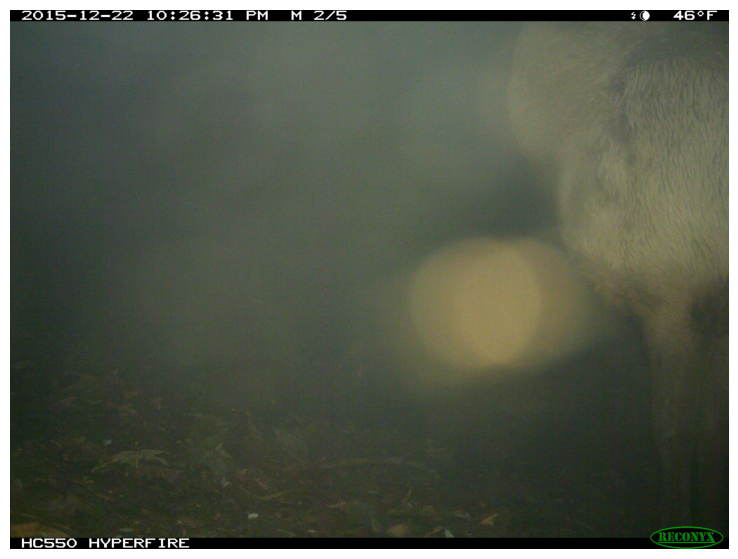

elk_count>  q


Saved and quit: /users/vmli3/CS370/elk_labels.csv


In [36]:
## from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image

print("Manual labeling (ELK only).")
print("Enter elk_count as a non-negative integer.")
print("Commands: s=skip, q=quit (saves), b=back (undo last manual label)")

history = []  # list of (filename, elk_count) manually labeled in this session

i = 0
while i < len(queue):
    rel = queue[i]
    img_path = IMAGES_ROOT / rel

    clear_output(wait=True)
    print(f"ELK manual labeling: {i+1}/{len(queue)}")
    print(f"File: {rel}")
    print("Commands: s=skip, q=quit (saves), b=back (undo last manual label)")

    # Close previous figures to avoid buildup
    plt.close("all")

    # Show image
    plt.figure(figsize=(10, 7))
    if img_path.exists():
        plt.imshow(Image.open(img_path))
        plt.axis("off")
        plt.show()
    else:
        print(f"⚠️ Missing file: {img_path}")

    ans = input("elk_count> ").strip().lower()

    if ans == "q":
        labels_df.to_csv(OUT_LABELS_CSV, index=False)
        print("Saved and quit:", OUT_LABELS_CSV.resolve())
        break

    if ans == "s":
        i += 1
        continue

    if ans == "b":
        if history:
            last_file, _last_count = history.pop()
            labels_df = labels_df[labels_df["filename"].astype(str) != last_file]
            labels_df.to_csv(OUT_LABELS_CSV, index=False)
            print(f"Undid: {last_file}")
            i = max(i - 1, 0)
        else:
            print("Nothing to undo.")
        continue

    try:
        count = int(ans)
        if count < 0:
            print("Please enter a non-negative integer.")
            continue

        # upsert this file's label
        labels_df = labels_df[labels_df["filename"].astype(str) != rel]
        labels_df = pd.concat(
            [labels_df, pd.DataFrame([{"filename": rel, "elk_count": count}])],
            ignore_index=True,
        )
        labels_df.to_csv(OUT_LABELS_CSV, index=False)
        history.append((rel, count))

        i += 1
    except ValueError:
        print("Invalid input. Enter an integer, or s/q/b.")